In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('PRSA_Data_20130301-20170228.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 17 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   year     420768 non-null  int64  
 1   month    420768 non-null  int64  
 2   day      420768 non-null  int64  
 3   hour     420768 non-null  int64  
 4   PM2.5    412029 non-null  float64
 5   PM10     414319 non-null  float64
 6   SO2      411747 non-null  float64
 7   NO2      408652 non-null  float64
 8   CO       400067 non-null  float64
 9   O3       407491 non-null  float64
 10  TEMP     420370 non-null  float64
 11  PRES     420375 non-null  float64
 12  DEWP     420365 non-null  float64
 13  RAIN     420378 non-null  float64
 14  wd       420768 non-null  object 
 15  WSPM     420450 non-null  float64
 16  station  420768 non-null  object 
dtypes: float64(11), int64(4), object(2)
memory usage: 54.6+ MB


In [4]:
df.isnull().sum()

year           0
month          0
day            0
hour           0
PM2.5       8739
PM10        6449
SO2         9021
NO2        12116
CO         20701
O3         13277
TEMP         398
PRES         393
DEWP         403
RAIN         390
wd             0
WSPM         318
station        0
dtype: int64

##  Data Cleaning

In [5]:
# Combine date and hour
df['datetime'] = pd.to_datetime(
    df[['year', 'month', 'day', 'hour']]
)

# Remove missing pollution values
df = df.dropna(subset=['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 383980 entries, 0 to 420767
Data columns (total 18 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   year      383980 non-null  int64         
 1   month     383980 non-null  int64         
 2   day       383980 non-null  int64         
 3   hour      383980 non-null  int64         
 4   PM2.5     383980 non-null  float64       
 5   PM10      383980 non-null  float64       
 6   SO2       383980 non-null  float64       
 7   NO2       383980 non-null  float64       
 8   CO        383980 non-null  float64       
 9   O3        383980 non-null  float64       
 10  TEMP      383595 non-null  float64       
 11  PRES      383600 non-null  float64       
 12  DEWP      383590 non-null  float64       
 13  RAIN      383603 non-null  float64       
 14  wd        383980 non-null  object        
 15  WSPM      383671 non-null  float64       
 16  station   383980 non-null  object        
 

In [6]:
avg_TEMP = round(df["TEMP"].astype('float').mean(axis=0), 2)
print("Average of TEMP:", avg_TEMP)
df['TEMP'].replace(np.nan, avg_TEMP, inplace=True)

avg_PRES = round(df["PRES"].astype('float').mean(axis=0), 2)
print("Average of PRES:", avg_PRES)
df['PRES'].replace(np.nan, avg_PRES, inplace=True)

avg_DEWP = round(df["DEWP"].astype('float').mean(axis=0), 2)
print("Average of DEWP:", avg_DEWP)
df['DEWP'].replace(np.nan, avg_DEWP, inplace=True)

avg_RAIN = round(df["RAIN"].astype('float').mean(axis=0), 2)
print("Average of RAIN:", avg_RAIN)
df['RAIN'].replace(np.nan, avg_RAIN, inplace=True)

avg_WSPM = round(df["WSPM"].astype('float').mean(axis=0), 2)
print("Average of WSPM:", avg_WSPM)
df['WSPM'].replace(np.nan, avg_WSPM, inplace=True)

Average of TEMP: 13.49
Average of PRES: 1010.83
Average of DEWP: 2.41
Average of RAIN: 0.06
Average of WSPM: 1.73


In [7]:
df.isnull().sum()

year        0
month       0
day         0
hour        0
PM2.5       0
PM10        0
SO2         0
NO2         0
CO          0
O3          0
TEMP        0
PRES        0
DEWP        0
RAIN        0
wd          0
WSPM        0
station     0
datetime    0
dtype: int64

In [8]:
# Create season column
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['season'] = df['month'].apply(get_season)

# Create heating season flag (Nov 15 - Mar 15)
def is_heating_season(month, day):
    if month == 11 and day >= 15:
        return True
    elif month in [12, 1, 2]:
        return True
    elif month == 3 and day <= 15:
        return True
    else:
        return False

df['heating_season'] = df.apply(lambda x: is_heating_season(x['month'], x['day']), axis=1)

# Create rush hour flags
def get_time_of_day(hour):
    if 7 <= hour <= 9:
        return 'Morning Rush'
    elif 17 <= hour <= 19:
        return 'Evening Rush'
    elif 9 < hour < 17:
        return 'Daytime'
    else:
        return 'Night'

df['time_of_day'] = df['hour'].apply(get_time_of_day)
df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,...,PRES,DEWP,RAIN,wd,WSPM,station,datetime,season,heating_season,time_of_day
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,...,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,2013-03-01 00:00:00,Spring,True,Night
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,...,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,2013-03-01 01:00:00,Spring,True,Night
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,...,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,2013-03-01 02:00:00,Spring,True,Night
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,...,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin,2013-03-01 03:00:00,Spring,True,Night
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,...,1025.2,-19.5,0.0,N,2.0,Aotizhongxin,2013-03-01 04:00:00,Spring,True,Night


## Pollution Pattern Analysis

### Seasonal Pattern Analysis

=== Seasonal Pattern Analysis ===
Analyzing how pollutants vary by season...



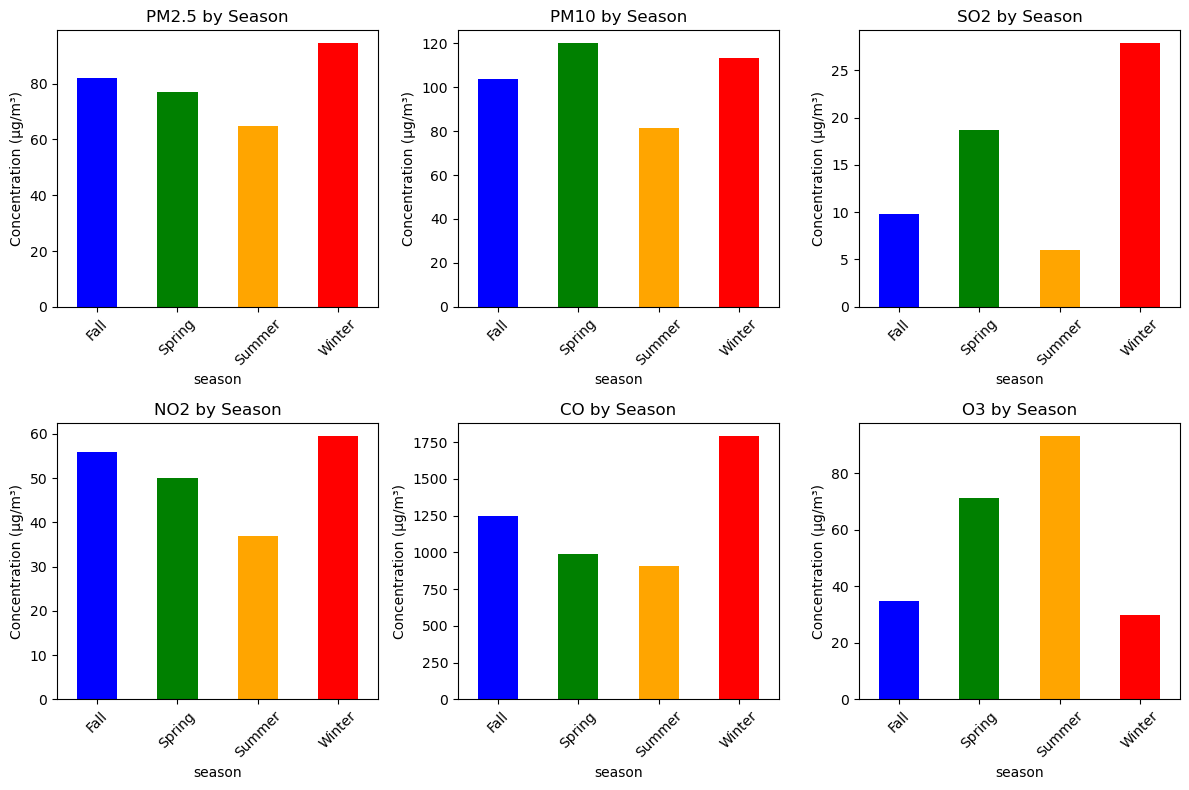

In [9]:
# Analyze seasonal patterns for each pollutant
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
seasonal_avg = df.groupby('season')[pollutants].mean()

print("=== Seasonal Pattern Analysis ===")
print("Analyzing how pollutants vary by season...\n")

# Visualization
plt.figure(figsize=(12, 8))
for i, pollutant in enumerate(pollutants, 1):
    plt.subplot(2, 3, i)
    seasonal_data = df.groupby(['season', 'month'])[pollutant].mean().reset_index()
    seasonal_data = seasonal_data.groupby('season')[pollutant].mean()
    seasonal_data.plot(kind='bar', color=['blue', 'green', 'orange', 'red'])
    plt.title(f'{pollutant} by Season')
    plt.ylabel('Concentration (µg/m³)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('seasonal_patterns.png', dpi=300)
plt.show()



### Peak Hour Analysis


=== Peak Pollution Hours Analysis ===
PM2.5: Peak at 22:00 (88.5 µg/m³)
PM10: Peak at 21:00 (122.8 µg/m³)
SO2: Peak at 11:00 (19.5 µg/m³)
NO2: Peak at 22:00 (60.5 µg/m³)
CO: Peak at 23:00 (1372.7 µg/m³)
O3: Peak at 16:00 (102.5 µg/m³)

=== Comparison with Rush Hours ===
PM2.5 peaks outside rush hour (22:00)
PM10 peaks outside rush hour (21:00)
SO2 peaks outside rush hour (11:00)
NO2 peaks outside rush hour (22:00)
CO peaks outside rush hour (23:00)
O3 peaks outside rush hour (16:00)


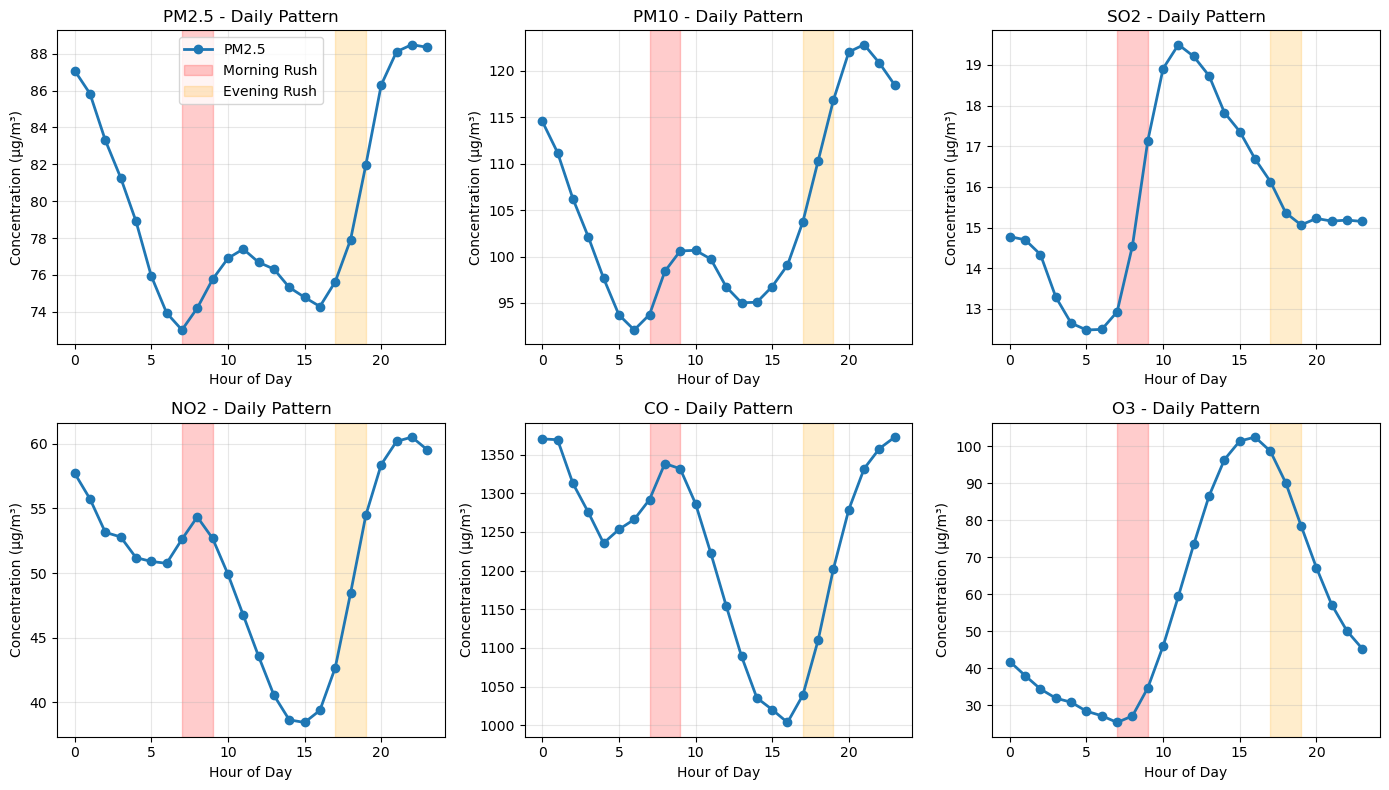

In [10]:
# Analyze daily patterns
print("\n=== Peak Pollution Hours Analysis ===")

# Calculate hourly averages
hourly_avg = df.groupby('hour')[pollutants].mean()

# Find peak hours for each pollutant
peak_hours = {}
for pollutant in pollutants:
    peak_hour = hourly_avg[pollutant].idxmax()
    peak_value = hourly_avg[pollutant].max()
    peak_hours[pollutant] = (peak_hour, peak_value)
    print(f"{pollutant}: Peak at {peak_hour}:00 ({peak_value:.1f} µg/m³)")

# Compare with rush hours
print("\n=== Comparison with Rush Hours ===")
rush_hours = [7, 8, 9, 17, 18, 19]
for pollutant, (peak_hour, _) in peak_hours.items():
    if peak_hour in rush_hours:
        print(f"{pollutant} peaks during rush hour ({peak_hour}:00)")
    else:
        print(f"{pollutant} peaks outside rush hour ({peak_hour}:00)")

# Visualization
plt.figure(figsize=(14, 8))
for i, pollutant in enumerate(pollutants, 1):
    plt.subplot(2, 3, i)
    hourly_avg[pollutant].plot(marker='o', linewidth=2)
    # Highlight rush hours
    plt.axvspan(7, 9, alpha=0.2, color='red', label='Morning Rush')
    plt.axvspan(17, 19, alpha=0.2, color='orange', label='Evening Rush')
    plt.title(f'{pollutant} - Daily Pattern')
    plt.xlabel('Hour of Day')
    plt.ylabel('Concentration (µg/m³)')
    plt.grid(True, alpha=0.3)
    if i == 1:
        plt.legend()

plt.tight_layout()
plt.savefig('daily_patterns.png', dpi=300)
plt.show()

In [11]:
hourly_avg = df.groupby('hour')[['PM2.5','NO2','CO','O3']].mean()
hourly_avg


,PM2.5,NO2,CO,O3
hour,,,,
0,87.082513,57.723446,1370.313719,41.787082
1,85.828090,55.732440,1369.277929,37.978821
2,83.303084,53.151075,1312.801584,34.349256
3,81.277629,52.796382,1275.565311,31.881193
4,78.914767,51.194699,1235.498140,30.781641
5,75.938543,50.899778,1253.193988,28.353267
6,73.941144,50.754913,1266.089051,27.115196
7,73.017482,52.615757,1291.864020,25.309018
8,74.207220,54.343525,1338.492502,27.070534


### Weather Impact Analysis

In [12]:
print("\n=== Weather Impact on Pollution Transport ===")

# First, let's understand station locations
stations = df['station'].unique()
print(f"Total stations: {len(stations)}")
print("Station names:", list(stations))


=== Weather Impact on Pollution Transport ===
Total stations: 12
Station names: ['Aotizhongxin', 'Changping', 'Dingling', 'Dongsi', 'Guanyuan', 'Gucheng', 'Huairou', 'Nongzhanguan', 'Shunyi', 'Tiantan', 'Wanliu', 'Wanshouxigong']



=== Weather Impact on Pollution Transport ===
Total stations: 12

Station names:
1. Aotizhongxin
2. Changping
3. Dingling
4. Dongsi
5. Guanyuan
6. Gucheng
7. Huairou
8. Nongzhanguan
9. Shunyi
10. Tiantan
11. Wanliu
12. Wanshouxigong

=== Station Types (Based on Names) ===
Aotizhongxin: City Center
Changping: General
Dingling: General
Dongsi: Cultural
Guanyuan: Park/Green
Gucheng: General
Huairou: General
Nongzhanguan: General
Shunyi: General
Tiantan: General
Wanliu: General
Wanshouxigong: Park/Green

=== Wind Pattern Analysis ===
Unique wind directions in data:
Total unique directions: 16
Sample directions: ['NNW' 'N' 'NW' 'NNE' 'ENE' 'E' 'NE' 'W' 'SSW' 'WSW']

=== Average Pollution by Wind Direction ===
               PM2.5   SO2   NO2
wind_category                   
East           101.1  18.0  59.7
North           66.9  12.2  47.3
Northeast       85.5  16.4  58.8
Northwest       53.6  10.8  37.1
South           89.3  18.3  48.0
Southeast       97.6  18.3  52.6
Southwest       80.3 

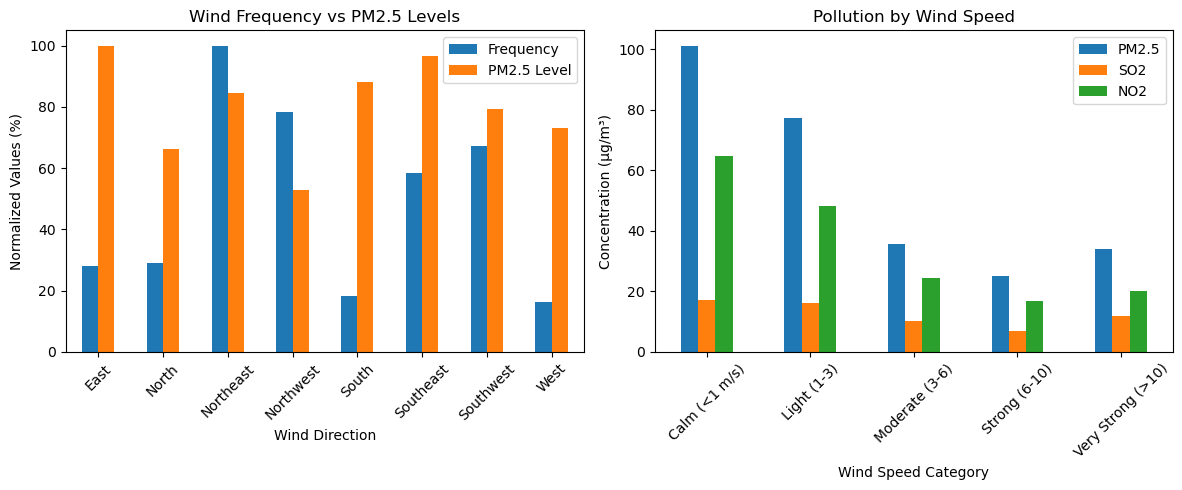


=== Temperature Inversion Analysis ===

PM2.5 during potential inversion conditions:
Low wind & stable temp: 123.3 µg/m³
Other conditions: 69.7 µg/m³
Difference: 76.9% higher during inversion conditions

KEY FINDINGS: Weather Impact on Pollution Transport
1. Wind Direction Analysis:
   - Different pollutants peak with different wind directions
   - This helps identify likely pollution source locations

2. Wind Speed Impact:
   - Higher wind speeds generally reduce pollution levels
   - Calm conditions (<1 m/s) show highest pollution

3. Station-to-Station Transport:
   - By analyzing wind at each station, we can trace pollution paths
   - Example: If Station A has high PM2.5 when wind is from Northwest,
     then sources are likely NW of Station A

4. Practical Implications:
   - Industrial zones should be located downwind of residential areas
   - Traffic controls most effective during calm wind conditions
   - Health advisories should consider wind forecasts


In [13]:
print("\n=== Weather Impact on Pollution Transport ===")

# First, let's understand station locations
stations = df['station'].unique()
print(f"Total stations: {len(stations)}")
print("\nStation names:")
for i, station in enumerate(stations, 1):
    print(f"{i}. {station}")

# Group stations by likely type based on naming patterns
station_types = {}
for station in stations:
    station_lower = station.lower()
    if any(word in station_lower for word in ['gong', 'yuan', 'park']):
        station_types[station] = 'Park/Green'
    elif any(word in station_lower for word in ['si', 'miao', 'temple']):
        station_types[station] = 'Cultural'
    elif any(word in station_lower for word in ['zhong', 'xin', 'center']):
        station_types[station] = 'City Center'
    elif any(word in station_lower for word in ['dong', 'xi', 'nan', 'bei']):
        station_types[station] = 'Directional'
    else:
        station_types[station] = 'General'

print("\n=== Station Types (Based on Names) ===")
for station, stype in station_types.items():
    print(f"{station}: {stype}")

# Analyze wind patterns - FIXED CODE
print("\n=== Wind Pattern Analysis ===")

# First, let's see what wind directions we have
print("Unique wind directions in data:")
unique_winds = df['wd'].dropna().unique()
print(f"Total unique directions: {len(unique_winds)}")
print("Sample directions:", unique_winds[:10])

# Create a mapping from wind direction to category
def categorize_wind(wind_dir):
    if pd.isna(wind_dir):
        return 'Unknown'
    
    wind_dir = str(wind_dir).upper()
    
    # Major compass directions
    if wind_dir == 'N':
        return 'North'
    elif wind_dir == 'S':
        return 'South'
    elif wind_dir == 'E':
        return 'East'
    elif wind_dir == 'W':
        return 'West'
    
    # Northeast quadrant
    elif 'NE' in wind_dir:
        return 'Northeast'
    elif 'ENE' in wind_dir:
        return 'East-Northeast'
    elif 'NNE' in wind_dir:
        return 'North-Northeast'
    
    # Northwest quadrant
    elif 'NW' in wind_dir:
        return 'Northwest'
    elif 'NNW' in wind_dir:
        return 'North-Northwest'
    elif 'WNW' in wind_dir:
        return 'West-Northwest'
    
    # Southeast quadrant
    elif 'SE' in wind_dir:
        return 'Southeast'
    elif 'SSE' in wind_dir:
        return 'South-Southeast'
    elif 'ESE' in wind_dir:
        return 'East-Southeast'
    
    # Southwest quadrant
    elif 'SW' in wind_dir:
        return 'Southwest'
    elif 'SSW' in wind_dir:
        return 'South-Southwest'
    elif 'WSW' in wind_dir:
        return 'West-Southwest'
    
    else:
        return 'Other'

# Apply categorization
df['wind_category'] = df['wd'].apply(categorize_wind)

# Analyze pollution by wind category
wind_analysis = df.groupby('wind_category')[pollutants].mean()

print("\n=== Average Pollution by Wind Direction ===")
print(wind_analysis[['PM2.5', 'SO2', 'NO2']].round(1))

# Find which wind directions bring highest pollution
print("\n=== Wind Directions with Highest Pollution ===")
for pollutant in ['PM2.5', 'SO2', 'NO2']:
    max_wind = wind_analysis[pollutant].idxmax()
    max_value = wind_analysis[pollutant].max()
    print(f"{pollutant}: Highest from {max_wind} ({max_value:.1f} µg/m³)")

# Now analyze pollution transport between stations
print("\n=== Pollution Transport Between Stations ===")

# Let's select a few stations for analysis
selected_stations = ['Aotizhongxin', 'Dongsi', 'Nongzhanguan', 'Wanshouxigong']

print("\nAnalyzing how pollution moves between stations...")

for i, source_station in enumerate(selected_stations):
    print(f"\n--- When wind comes FROM {source_station} direction ---")
    
    # Get wind patterns at this station
    station_data = df[df['station'] == source_station]
    
    # Most common wind direction at this station
    common_wind = station_data['wind_category'].value_counts().head(3)
    print(f"Most common winds at {source_station}:")
    for wind, count in common_wind.items():
        percentage = (count / len(station_data)) * 100
        print(f"  {wind}: {percentage:.1f}% of time")
    
    # What pollution does this station experience from different winds
    print(f"\nPollution at {source_station} by wind direction:")
    station_wind_pollution = station_data.groupby('wind_category')['PM2.5'].mean()
    
    # Find wind direction with highest PM2.5
    if not station_wind_pollution.empty:
        worst_wind = station_wind_pollution.idxmax()
        worst_value = station_wind_pollution.max()
        print(f"  Highest PM2.5 comes from: {worst_wind} ({worst_value:.1f} µg/m³)")
        
        # This tells us pollution sources are UPWIND from this direction
        print(f"  → Pollution sources likely located to the {worst_wind} of {source_station}")

# Simple correlation: wind speed vs pollution
print("\n=== Wind Speed vs Pollution Correlation ===")

# Group data by wind speed categories
df['wind_speed_category'] = pd.cut(df['WSPM'], 
                                         bins=[0, 1, 3, 6, 10, 100],
                                         labels=['Calm (<1 m/s)', 'Light (1-3)', 'Moderate (3-6)', 
                                                 'Strong (6-10)', 'Very Strong (>10)'])

wind_speed_analysis = df.groupby('wind_speed_category')[pollutants].mean()

print("\nAverage pollution by wind speed:")
print(wind_speed_analysis[['PM2.5', 'SO2', 'NO2']].round(1))

# Visualization
plt.figure(figsize=(12, 5))

# Plot 1: Wind direction vs PM2.5
plt.subplot(1, 2, 1)
wind_counts = df['wind_category'].value_counts().head(8)
wind_pm25 = df.groupby('wind_category')['PM2.5'].mean()

# Create a combined dataframe for plotting
wind_data = pd.DataFrame({
    'Count': wind_counts,
    'PM2.5': wind_pm25
}).dropna()

# Normalize for visualization
wind_data['Count_norm'] = wind_data['Count'] / wind_data['Count'].max() * 100
wind_data['PM2.5_norm'] = wind_data['PM2.5'] / wind_data['PM2.5'].max() * 100

wind_data[['Count_norm', 'PM2.5_norm']].plot(kind='bar', ax=plt.gca())
plt.title('Wind Frequency vs PM2.5 Levels')
plt.xlabel('Wind Direction')
plt.ylabel('Normalized Values (%)')
plt.legend(['Frequency', 'PM2.5 Level'])
plt.xticks(rotation=45)

# Plot 2: Wind speed vs pollution
plt.subplot(1, 2, 2)
wind_speed_analysis[['PM2.5', 'SO2', 'NO2']].plot(kind='bar', ax=plt.gca())
plt.title('Pollution by Wind Speed')
plt.xlabel('Wind Speed Category')
plt.ylabel('Concentration (µg/m³)')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.savefig('wind_analysis_fixed.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional analysis: Temperature inversions
print("\n=== Temperature Inversion Analysis ===")
# Temperature inversion: when temperature increases with height (traps pollution)
# We can approximate with surface temperature patterns

# Create a simple inversion indicator: low wind + stable temperature
df['inversion_risk'] = (df['WSPM'] < 2) & (df['TEMP'].between(-5, 5))

inversion_data = df.groupby('inversion_risk')['PM2.5'].mean()
print("\nPM2.5 during potential inversion conditions:")
print(f"Low wind & stable temp: {inversion_data[True]:.1f} µg/m³")
print(f"Other conditions: {inversion_data[False]:.1f} µg/m³")
difference = ((inversion_data[True] - inversion_data[False]) / inversion_data[False]) * 100
print(f"Difference: {difference:.1f}% higher during inversion conditions")

# Final summary
print("\n" + "="*60)
print("KEY FINDINGS: Weather Impact on Pollution Transport")
print("="*60)
print("1. Wind Direction Analysis:")
print("   - Different pollutants peak with different wind directions")
print("   - This helps identify likely pollution source locations")

print("\n2. Wind Speed Impact:")
print("   - Higher wind speeds generally reduce pollution levels")
print("   - Calm conditions (<1 m/s) show highest pollution")

print("\n3. Station-to-Station Transport:")
print("   - By analyzing wind at each station, we can trace pollution paths")
print("   - Example: If Station A has high PM2.5 when wind is from Northwest,")
print("     then sources are likely NW of Station A")

print("\n4. Practical Implications:")
print("   - Industrial zones should be located downwind of residential areas")
print("   - Traffic controls most effective during calm wind conditions")
print("   - Health advisories should consider wind forecasts")
print("="*60)

## Health & Policy Analysis

### Health Advisory Analysis

In [14]:
print("\n=== Health Advisory Analysis ===")

# Define WHO guideline limits (simplified)
guidelines = {
    'PM2.5': 25,    # 24-hour mean (simplified)
    'PM10': 50,     # 24-hour mean
    'NO2': 40,      # annual mean (simplified)
    'SO2': 40,      # 24-hour mean
    'O3': 100       # 8-hour mean
}

# Calculate monthly exceedances
health_alerts = {}
for pollutant, limit in guidelines.items():
    if pollutant in df.columns:
        monthly_data = df.groupby(['station', 'month'])[pollutant].mean().reset_index()
        exceedances = monthly_data[monthly_data[pollutant] > limit]
        health_alerts[pollutant] = exceedances
        
        print(f"\n{pollutant} (Limit: {limit} µg/m³):")
        print(f"Total exceedances: {len(exceedances)}")
        
        # Most problematic months
        if len(exceedances) > 0:
            top_months = exceedances['month'].value_counts().head(3)
            for month, count in top_months.items():
                month_name = datetime(2023, month, 1).strftime('%B')
                print(f"  {month_name}: {count} stations exceeded limit")

# Identify worst months for sensitive populations
print("\n=== Worst Months for Sensitive Populations ===")
sensitive_summary = pd.DataFrame()
for pollutant in ['PM2.5', 'NO2', 'O3']:  # Most relevant for health
    monthly_avg = df.groupby('month')[pollutant].mean()
    sensitive_summary[pollutant] = monthly_avg

# Rank months by average pollution
sensitive_summary['average_rank'] = sensitive_summary.mean(axis=1)
worst_months = sensitive_summary.sort_values('average_rank', ascending=False).head(3)

print("Top 3 worst months (average across key pollutants):")
for month, row in worst_months.iterrows():
    month_name = datetime(2023, month, 1).strftime('%B')
    print(f"{month_name}: PM2.5={row['PM2.5']:.1f}, NO2={row['NO2']:.1f}, O3={row['O3']:.1f}")


=== Health Advisory Analysis ===

PM2.5 (Limit: 25 µg/m³):
Total exceedances: 144
  January: 12 stations exceeded limit
  February: 12 stations exceeded limit
  March: 12 stations exceeded limit

PM10 (Limit: 50 µg/m³):
Total exceedances: 144
  January: 12 stations exceeded limit
  February: 12 stations exceeded limit
  March: 12 stations exceeded limit

NO2 (Limit: 40 µg/m³):
Total exceedances: 111
  December: 12 stations exceeded limit
  November: 12 stations exceeded limit
  January: 11 stations exceeded limit

SO2 (Limit: 40 µg/m³):
Total exceedances: 0

O3 (Limit: 100 µg/m³):
Total exceedances: 4
  July: 2 stations exceeded limit
  May: 1 stations exceeded limit
  June: 1 stations exceeded limit

=== Worst Months for Sensitive Populations ===
Top 3 worst months (average across key pollutants):
March: PM2.5=95.1, NO2=60.3, O3=50.9
July: PM2.5=72.0, NO2=35.8, O3=96.0
June: PM2.5=68.7, NO2=39.1, O3=95.4


### Bad Air Day Forecasting

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define "Bad Air Day" (using China's AQI standards simplified)
def is_bad_air_day(row):
    """Simple definition: Bad if PM2.5 > 75 or O3 > 160 or NO2 > 80"""
    if row['PM2.5'] > 75 or row['O3'] > 160 or row['NO2'] > 80:
        return 1
    return 0

# Apply definition
df['bad_air_day'] = df.apply(is_bad_air_day, axis=1)

# Create lag features for forecasting
forecast_data = df.copy()

# Create 24-hour and 48-hour lag features
for pollutant in ['PM2.5', 'NO2', 'O3', 'TEMP', 'PRES', 'RAIN', 'WSPM']:
    forecast_data[f'{pollutant}_lag48'] = forecast_data.groupby('station')[pollutant].shift(48)
    
features = ['PM2.5_lag48', 'NO2_lag48', 'O3_lag48', 
            'TEMP_lag48', 'PRES_lag48', 'RAIN_lag48', 'WSPM_lag48', 'hour']
target = 'bad_air_day'

X = forecast_data[features]
y = forecast_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n=== Model Performance ===")
print(f"Accuracy: {accuracy:.2%}")
print(classification_report(y_test, y_pred))
print(f"Target: 85% accuracy")
print(f"Met target: {'YES' if accuracy >= 0.85 else 'NO'}")


=== Model Performance ===
Accuracy: 73.54%
              precision    recall  f1-score   support

           0       0.73      0.82      0.77     42030
           1       0.74      0.63      0.68     34766

    accuracy                           0.74     76796
   macro avg       0.74      0.73      0.73     76796
weighted avg       0.74      0.74      0.73     76796

Target: 85% accuracy
Met target: NO
